In [1]:
from __future__ import division

import os
import numpy as np
import time, timeit
import signal
import scipy.io as scio
from scipy import stats
from scipy.sparse import coo_matrix
from MDPD.readers import *
from MDPD import utils, MDPD
import matplotlib.pyplot as plt
import matplotlib
import pickle

----
## Read Data

In [6]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/'
# folder = '/Users/vincent/Documents/Research/MDPD/crowdsourcing_datasets'

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'bird', 'bluebird_crowd.txt'), os.path.join(folder, 'bird', 'bluebird_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:], dtype=np.bool)
print(train.shape)

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'dog', 'dog_crowd.txt'), os.path.join(folder, 'dog', 'dog_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'rte', 'rte_crowd.txt'), os.path.join(folder, 'rte', 'rte_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print(train.shape)

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'trec', 'trec_crowd.txt'), os.path.join(folder, 'trec', 'trec_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

In [7]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'web', 'web_crowd.txt'), os.path.join(folder, 'web', 'web_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print(train.shape)

2018-05-17 11:38:12,791 : INFO : Data has missing values. A new label is created to represent the missing values.


(2653, 177, 6)


#### Update global variables

In [8]:
NSAMPLE, DIM, NVOCAB = train.shape
EFF_NVOCAB = NVOCAB-1 if reader.is_missing_value else NVOCAB

---
# Analysis

## Original Mutual Information Residue

In [ ]:
%%time
# Original mutual information residue (G score)
score_origin = utils.Feature_Selection.MI_score(train, rm_diag=True, lock=lock)
sigma_origin = score_origin.sum(axis=1)
print(np.sum(score_origin) / (DIM * (DIM-1)))

#### Reference G Statistics

In [ ]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100., (EFF_NVOCAB**2 - 1)) / (2 * NSAMPLE) for x in percentages]
print('Reference G statistis at {} percentile'.format(percentages))
print(percentiles)

---
## Mutual Information Residue if use the true label as the posterior distribution

In [ ]:
# label to log_post
def label2logpost(label, ncomp):
    nsample = label.shape[0]
    post = np.zeros((nsample, ncomp))
    for i in range(nsample):
        post[i, label[i]] = 1
    return np.log(post)
log_post = label2logpost(label,label.max()+1)
utils.log_replace_neginf(log_post)

In [ ]:
%%time
score, weights = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
score_condition = score.sum(axis=1)
print('Mutual Information Residue if use the true label as the posterior distribution')
print(np.sum(score_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1)))

#### [Plot] Mutual Information Residue if use the true label as the posterior distribution vs. Raw Residue

In [ ]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in range(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM - 1))
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

In [ ]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
plt.plot(np.sum(score_condition[idx,:] * weights[np.newaxis, :], axis=1) / (DIM - 1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

---
## Mixture Model with Feature Selection

#### Feature Ranking

In [9]:
%%time
score = utils.Feature_Selection.MI_score(train, lock=lock)
sigma = score.sum(axis=1)
features = np.argsort(sigma)[::-1]
sigma = sigma[features]
# features, sigma = utils.Feature_Selection.MI_feature_ranking(train, lock=lock)
print(features)

[  2   7   0  11  12   6   1  15  25  13  10   3  44  32 102   5  69  38
  29  36   8  62 106  58 103  56  46  27  24  23  52  51  28  41  21  31
  74  68  33  35  77  99  75  64 114  50  82  17 142 109 117  65 107 100
  30 129  93  19  26 105  40  86  98  90  59  37  91 112  78  34  81  67
 120 126   4  70 134  61   9  83  47  18 130  71  49 135 124  96 127  92
 119  72  88 104  48 108  55  85 144  14 118  16  39  87 101  60 139  89
  54 155 140 132  63  84  94 113 138 145  95 158  22  42 116 165  80  57
  45  66 164 143  53 147  76 125 161 123 128 153 141 121  79  20  97 131
 111 160 122  43 157  73 115 133 110 156 148 150 173 137 146 162 168 159
 175 169 167 176 163 171 136 172 166 151 154 170 149 174 152]
CPU times: user 481 ms, sys: 60.8 ms, total: 541 ms
Wall time: 308 ms


/home/vzhao/Documents/Projects/MDPD/python/MDPD/utils.py:238: RuntimeWarning: divide by zero encountered in log
  log_second_scaled = np.log(second_masked)


#### Accuracy and Mutual Information Residue

In [13]:
Ntop = 50

In [14]:
%%time
# Feature Selection + EM
model = MDPD.MDPD_standard()
model.fit(train, EFF_NVOCAB, features=features[:Ntop], init='spectral', verbose=False, epoch=50, lock=lock)
model.accuracy(train, label)
model.MI_residue(train)

2018-05-17 11:40:16,688 : INFO : Training an MDPD using batch EM 
	 dimension: 177 
	 features: 50 
	 sample size: 2653 
	 vocab size: 6 
	 the target number of components: 5
	 epoch: 50
	 initiated by: spectral
2018-05-17 11:40:33,682 : INFO : ACCURACY: 83.45%
/home/vzhao/Documents/Projects/MDPD/python/MDPD/utils.py:238: RuntimeWarning: divide by zero encountered in log
  log_second_scaled = np.log(second_masked)
2018-05-17 11:40:35,681 : INFO : The mutual information residue (include all features) is 0.021431297836945196
2018-05-17 11:40:35,684 : INFO : The mutual information residue (within selected features) is 0.0892383546103692


CPU times: user 35.4 s, sys: 3.46 s, total: 38.9 s
Wall time: 19 s


In [ ]:
# optional
model.change_features(train, features=range(model.dim))
model.accuracy(train, label)

#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

In [ ]:
log_post = model.log_posterior(train)
score, weights = utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
sigma_condition = score.sum(axis=1)
print 'Mutual Information Residue of the model with feature selection'
print np.sum(sigma_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

In [ ]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM-1))
plt.plot(sigma_origin[idx] / (DIM-1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

In [ ]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM-1), '--')
plt.plot(np.sum(score_condition[idx, :] * weights[np.newaxis, :], axis=1) / (DIM-1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

## Vanilla Model Performance
#### Accuracy and Mutual Information Residue

In [ ]:
# basic model with majority vote initialization
model_basic = MDPD.MDPD_standard()
model_basic.fit(train, ncomp=EFF_NVOCAB, init='majority', verbose=False, epoch=50, lock=lock)
model_basic.accuracy(train, label)
model_basic.MI_residue(train)

In [ ]:
log_post = model_basic.log_posterior(train)
score, weights = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
score_condition = score.sum(axis=1)
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(score_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

print 'Mutual Information Residue (within the selected features)'
score_select = score[features[:Ntop, np.newaxis], features[:Ntop], :]
res_select = np.sum(score_select.sum(axis=1) * weights[np.newaxis, :]) / (Ntop * (Ntop - 1))
print res_select

#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

In [ ]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM - 1))
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

In [ ]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
plt.plot(np.sum(score_condition[idx,:] * weights[np.newaxis, :], axis=1) / (DIM - 1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

---
## Generate Image

#### NIPS 2018

Missing Values

In [ ]:
plt.imshow(1-train[..., -1], origin='lower', cmap='PuBu')
plt.axis('normal')
plt.xlabel('Worker Index', fontsize=15)
plt.ylabel('Item Index', fontsize=15)

Error Rate vs. number of features

/home/vzhao/Documents/Projects/MDPD/python/MDPD/utils.py:238: RuntimeWarning: divide by zero encountered in log
  log_second_scaled = np.log(second_masked)


[  2   7   0  11  12   6   1  15  25  13  10   3  44  32 102   5  69  38
  29  36   8  62 106  58 103  56  46  27  24  23  52  51  28  41  21  31
  74  68  33  35  77  99  75  64 114  50  82  17 142 109 117  65 107 100
  30 129  93  19  26 105  40  86  98  90  59  37  91 112  78  34  81  67
 120 126   4  70 134  61   9  83  47  18 130  71  49 135 124  96 127  92
 119  72  88 104  48 108  55  85 144  14 118  16  39  87 101  60 139  89
  54 155 140 132  63  84  94 113 138 145  95 158  22  42 116 165  80  57
  45  66 164 143  53 147  76 125 161 123 128 153 141 121  79  20  97 131
 111 160 122  43 157  73 115 133 110 156 148 150 173 137 146 162 168 159
 175 169 167 176 163 171 136 172 166 151 154 170 149 174 152]
CPU times: user 403 ms, sys: 45.3 ms, total: 449 ms
Wall time: 365 ms


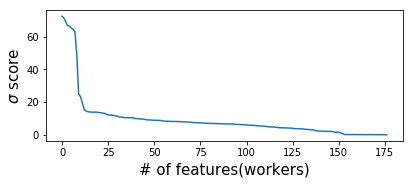

In [31]:
%%time
score = utils.Feature_Selection.MI_score(train, lock=lock)
sigma = score.sum(axis=1)
features = np.argsort(sigma)[::-1]
sigma = sigma[features]
# features, sigma = utils.Feature_Selection.MI_feature_ranking(train, lock=lock)
plt.figure(figsize=(6.4,2.4))
plt.plot(sigma)
plt.xlabel('# of features(workers)', fontsize=15)
plt.ylabel(r'$\sigma$ score', fontsize=15)
print(features)

In [ ]:
x_range = range(6, 178)
mvem_err = []
spec_err = []
for Ntop in x_range:
#     print(Ntop)
    # solve if no training data on one item
    mask = train[:, features[:Ntop], -1].sum(axis=1) != Ntop
    train_valid, label_valid = train[mask, :, :], label[mask]
    item_to_guess = len(label) - mask.sum()
    # mvem
    model = MDPD.MDPD_standard()
    model.fit(train_valid, EFF_NVOCAB, features=features[:Ntop], init='majority', verbose=False, epoch=100, lock=lock)
    total_right = model.accuracy(train_valid, label_valid) * len(label_valid) + item_to_guess / EFF_NVOCAB
    mvem_err.append(1 - total_right / len(label))
    # spec
    cache = []
    for _ in range(20):
        try:
            model = MDPD.MDPD_standard()
            model.fit(train, 5, features=features[:Ntop], init='spectral', verbose=False, epoch=100, lock=lock)
            cache.append(model.accuracy(train, label))
        except:
            pass
    spec_err.append(cache)

In [ ]:
mvem_err

In [ ]:
train.shape

In [ ]:
mask = train[:, features[:5], -1].sum(axis=1) != 5

In [ ]:
lock.shape

In [ ]:
mask.sum()

In [ ]:
label.shape

Read .p files

In [15]:
x_range = range(6, 178)
mv_err = pickle.load(open('NIPS_2018_WEB_MV.p','rb'))
mvem_err = pickle.load(open('NIPS_2018_WEB_MVEM.p','rb'))

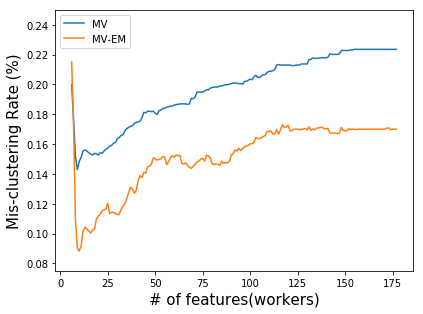

In [39]:
plt.figure(figsize=(6.4,4.8))
plt.plot(x_range, mv_err)
plt.plot(x_range, mvem_err)
plt.xlabel('# of features(workers)', fontsize=15)
plt.ylabel('Mis-clustering Rate (%)', fontsize=15)
plt.ylim([0.075,0.25])
plt.legend(['MV', 'MV-EM', 'Spec-EM'],loc=2)

In [78]:
np.argmin(mvem_err)

4

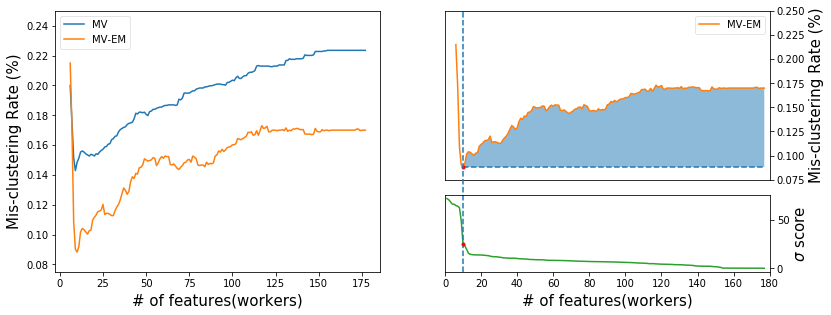

In [121]:
plt.figure(figsize=(12.8,4.8))

plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot(x_range, mv_err)
plt.plot(x_range, mvem_err)
plt.xlabel('# of features(workers)', fontsize=15)
plt.ylabel('Mis-clustering Rate (%)', fontsize=15)
plt.ylim([0.075,0.25])
plt.legend(['MV', 'MV-EM', 'Spec-EM'],loc=2,fancybox=True, framealpha=0.5)

ax = plt.subplot2grid((3, 2), (0, 1), rowspan=2)
newx = np.array(x_range)[4:]
y1 = mvem_err[4:]
y2 = np.ones(newx.shape) * np.min(mvem_err)

plt.plot(x_range, mvem_err,color='C1')
plt.plot(newx, y2, '--')
ax.fill_between(newx, y1, y2, alpha=0.5)

plt.plot(x_range[4], mvem_err[4], 'r.')

# plt.xlabel('# of features(workers)', fontsize=15)
plt.ylabel('Mis-clustering Rate (%)', fontsize=15)
plt.ylim([0.075,0.25])
plt.xlim([0, 180])
ax.get_xaxis().set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position("right")
# ax.set_xticklabels([])
plt.legend(['MV-EM'],fancybox=True, framealpha=0.5)

ax = plt.subplot2grid((3, 2), (2, 1))

x = np.arange(len(sigma)) + 1
plt.plot(x, sigma,color='C2')

ax.axvline(x[9], 0, 3.4, clip_on=False, linestyle='--')
plt.plot(x[9], sigma[9], 'r.')

plt.xlim([0, 180])
plt.xlabel('# of features(workers)', fontsize=15)
plt.ylabel(r'$\sigma$ score', fontsize=15)
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position("right")